In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA, NMF

import shap
import optuna

import lightgbm as lgb
import xgboost as xgb
from imblearn.ensemble import BalancedRandomForestClassifier

import warnings
warnings.filterwarnings("ignore")

sns.set_style('whitegrid')
from colorama import Style, Fore
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
gren = Style.BRIGHT + Fore.GREEN
res = Style.RESET_ALL

In [3]:
df = pd.read_csv('data.csv', index_col=[0])
df.head()

Product ID Type  Air temperature [K]  Process temperature [K]  \
id                                                                 
0      L50096    L                300.6                    309.6   
1      M20343    M                302.6                    312.1   
2      L49454    L                299.3                    308.5   
3      L53355    L                301.0                    310.9   
4      M24050    M                298.0                    309.0   

    Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  \
id                                                                          
0                     1596         36.1              140                0   
1                     1759         29.1              200                0   
2                     1805         26.5               25                0   
3                     1524         44.3              197                0   
4                     1641         35.4               34                0   

    TWF  HDF  PWF  OSF  RNF  
id                           
0     0    0    0    0    0  
1     0    0    0    0    0  
2     0    0    0    0    0  
3     0    0    0    0    0  
4     0    0    0    0    0

In [4]:
df['Product ID'] = df['Product ID'].str.replace('M','').str.replace('L','').str.replace('H','').astype(int)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136429 entries, 0 to 136428
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       136429 non-null  int64  
 1   Product ID               136429 non-null  object 
 2   Type                     136429 non-null  object 
 3   Air temperature [K]      136429 non-null  float64
 4   Process temperature [K]  136429 non-null  float64
 5   Rotational speed [rpm]   136429 non-null  int64  
 6   Torque [Nm]              136429 non-null  float64
 7   Tool wear [min]          136429 non-null  int64  
 8   Machine failure          136429 non-null  int64  
 9   TWF                      136429 non-null  int64  
 10  HDF                      136429 non-null  int64  
 11  PWF                      136429 non-null  int64  
 12  OSF                      136429 non-null  int64  
 13  RNF                      136429 non-null  int64  
dtypes: f

In [45]:
def set_frame_style(df, caption=""):
  return df.style.background_gradient(cmap='viridis').set_caption(caption).set_table_styles([{
  'selector': 'caption',
  'props': [
      ('color', 'Green'),
      ('font-size', '18px'),
      ('font-weight','bold')
  ]}])

def check_data(data):
  cols = data.columns.to_list()
  display(set_frame_style(data[cols].describe(),f'Summary Statistics'))
  display(set_frame_style(data[cols].nunique().to_frame().rename({0:'Unique Value Count'}, axis=1).transpose(), f'Unique Value Counts In Each Column'))
  display(set_frame_style(data[cols].isna().sum().to_frame().transpose(), f'Columns With Nan'))
    
check_data(df)

In [46]:
target_col = 'Machine failure'
bin_cols = [col for col in df.columns if df[col].nunique() == 2 and col != target_col]
num_cols = df.select_dtypes(include=['number']).columns.difference([target_col]).difference(bin_cols).to_list()
cat_cols = df.select_dtypes(include=['object']).columns.difference([target_col]).difference(bin_cols).to_list()

print(f"{blu}Number of numerical columns: {len(num_cols)}")
print(f"List of numerical columns: {num_cols}")
print('-'*50)
print(f"Number of categorical columns: {len(cat_cols)}")
print(f"List of categorical columns: {cat_cols}")
print('-'*50)
print(f"Number of binary columns: {len(bin_cols)}")
print(f"List of binary columns: {bin_cols}")
print('-'*50)
print(f"{gren}Target column: {target_col}")
print(f"Dataset shape: {df.shape}")

Number of numerical columns: 5
List of numerical columns: ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Tool wear [min]', 'Torque [Nm]']
--------------------------------------------------
Number of categorical columns: 2
List of categorical columns: ['Product ID', 'Type']
--------------------------------------------------
Number of binary columns: 5
List of binary columns: ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
--------------------------------------------------
Target column: Machine failure
Dataset shape: (136429, 13)


## EDA

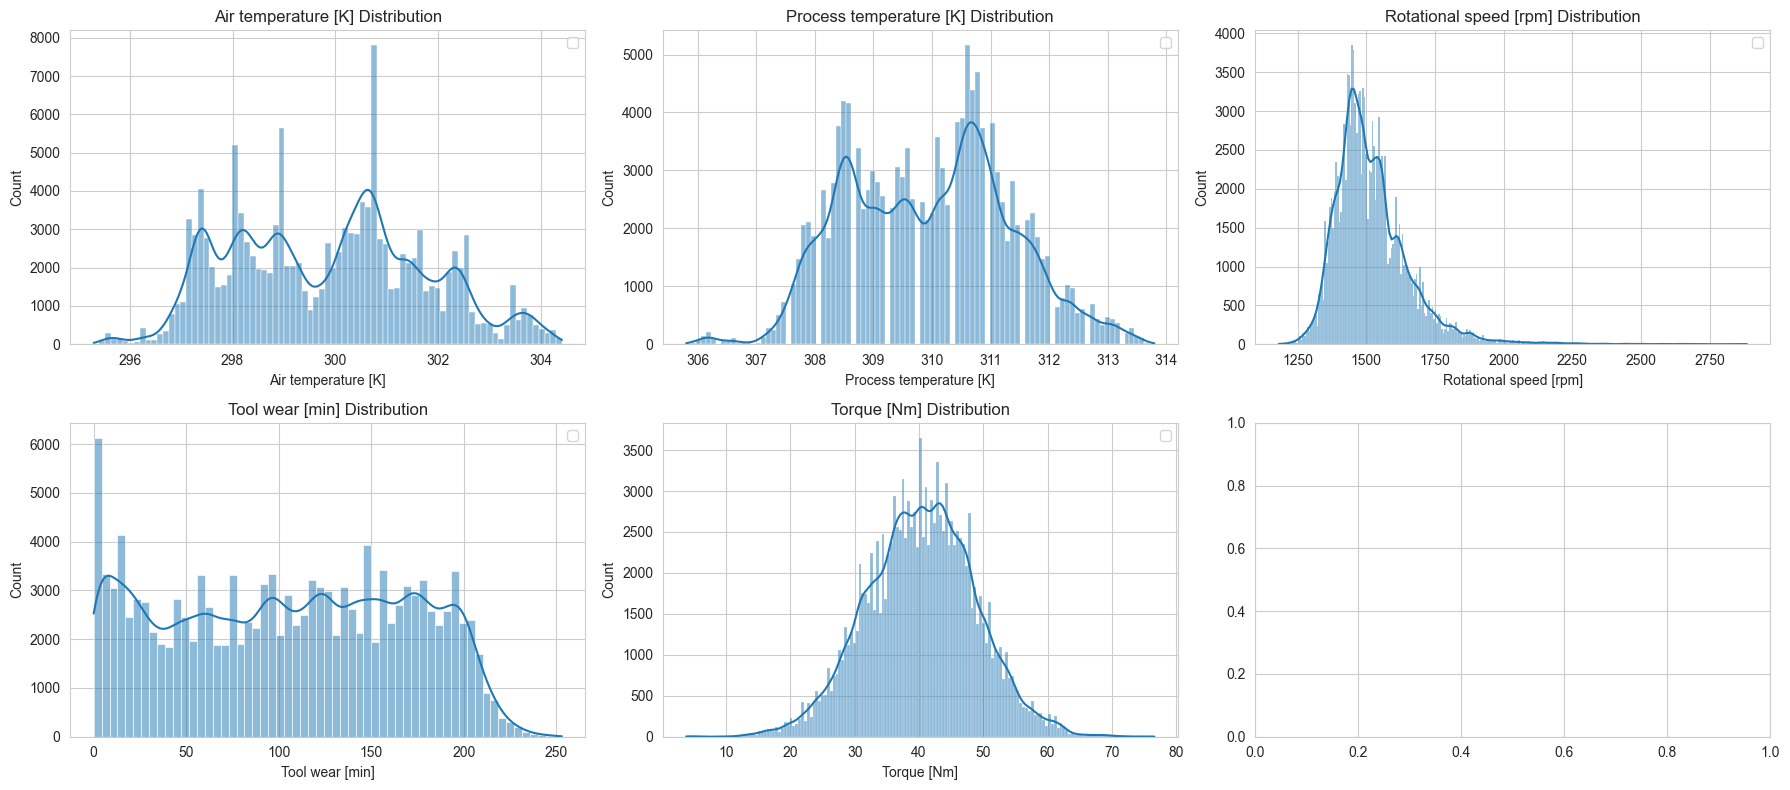

In [47]:
def plot_histograms(df, n_cols=3):
  n_rows = math.ceil(len(df.columns.tolist()) / n_cols)

  fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 4*n_rows))
  ax = ax.flatten()

  for i, col in enumerate(df.columns.tolist()):
    sns.histplot(data=df, x=col, multiple='stack', ax=ax[i], kde=True)
    ax[i].set_title(f'{col} Distribution')
    ax[i].set_xlabel(f'{col}')
    ax[i].set_ylabel('Count')
    ax[i].legend()

  plt.tight_layout()
  plt.show()
        
plot_histograms(df[num_cols], n_cols=3)

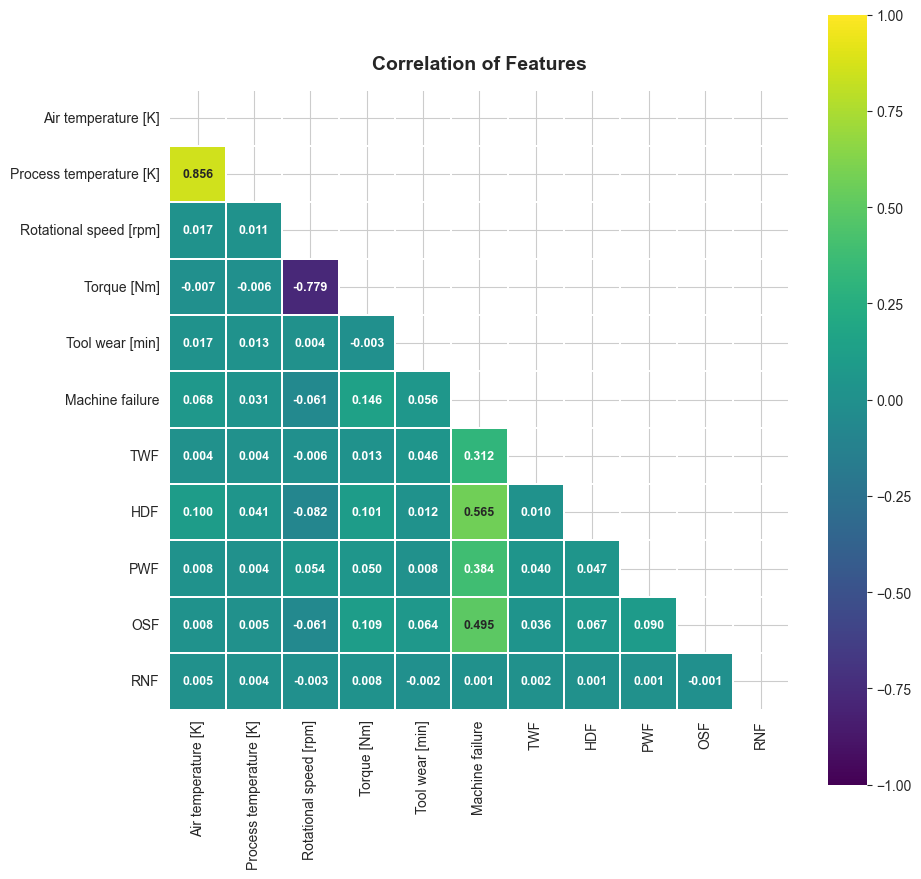

In [48]:
def plot_heatmap(df):
  mask = np.triu(df.astype(float).corr())
  plt.figure(figsize=(10, 10))
  plt.title(f'Correlation of Features', fontweight='bold', y=1.02, size=14)
  sns.heatmap(df.astype(float).corr(), linewidths=0.1, vmax=1.0, vmin=-1.0, 
              square=True, cmap='viridis', linecolor='white', annot=True, annot_kws={"size": 9, "weight": "bold"}, fmt=".3f", mask=mask)

plot_heatmap(df[df.select_dtypes(include=['number']).columns])

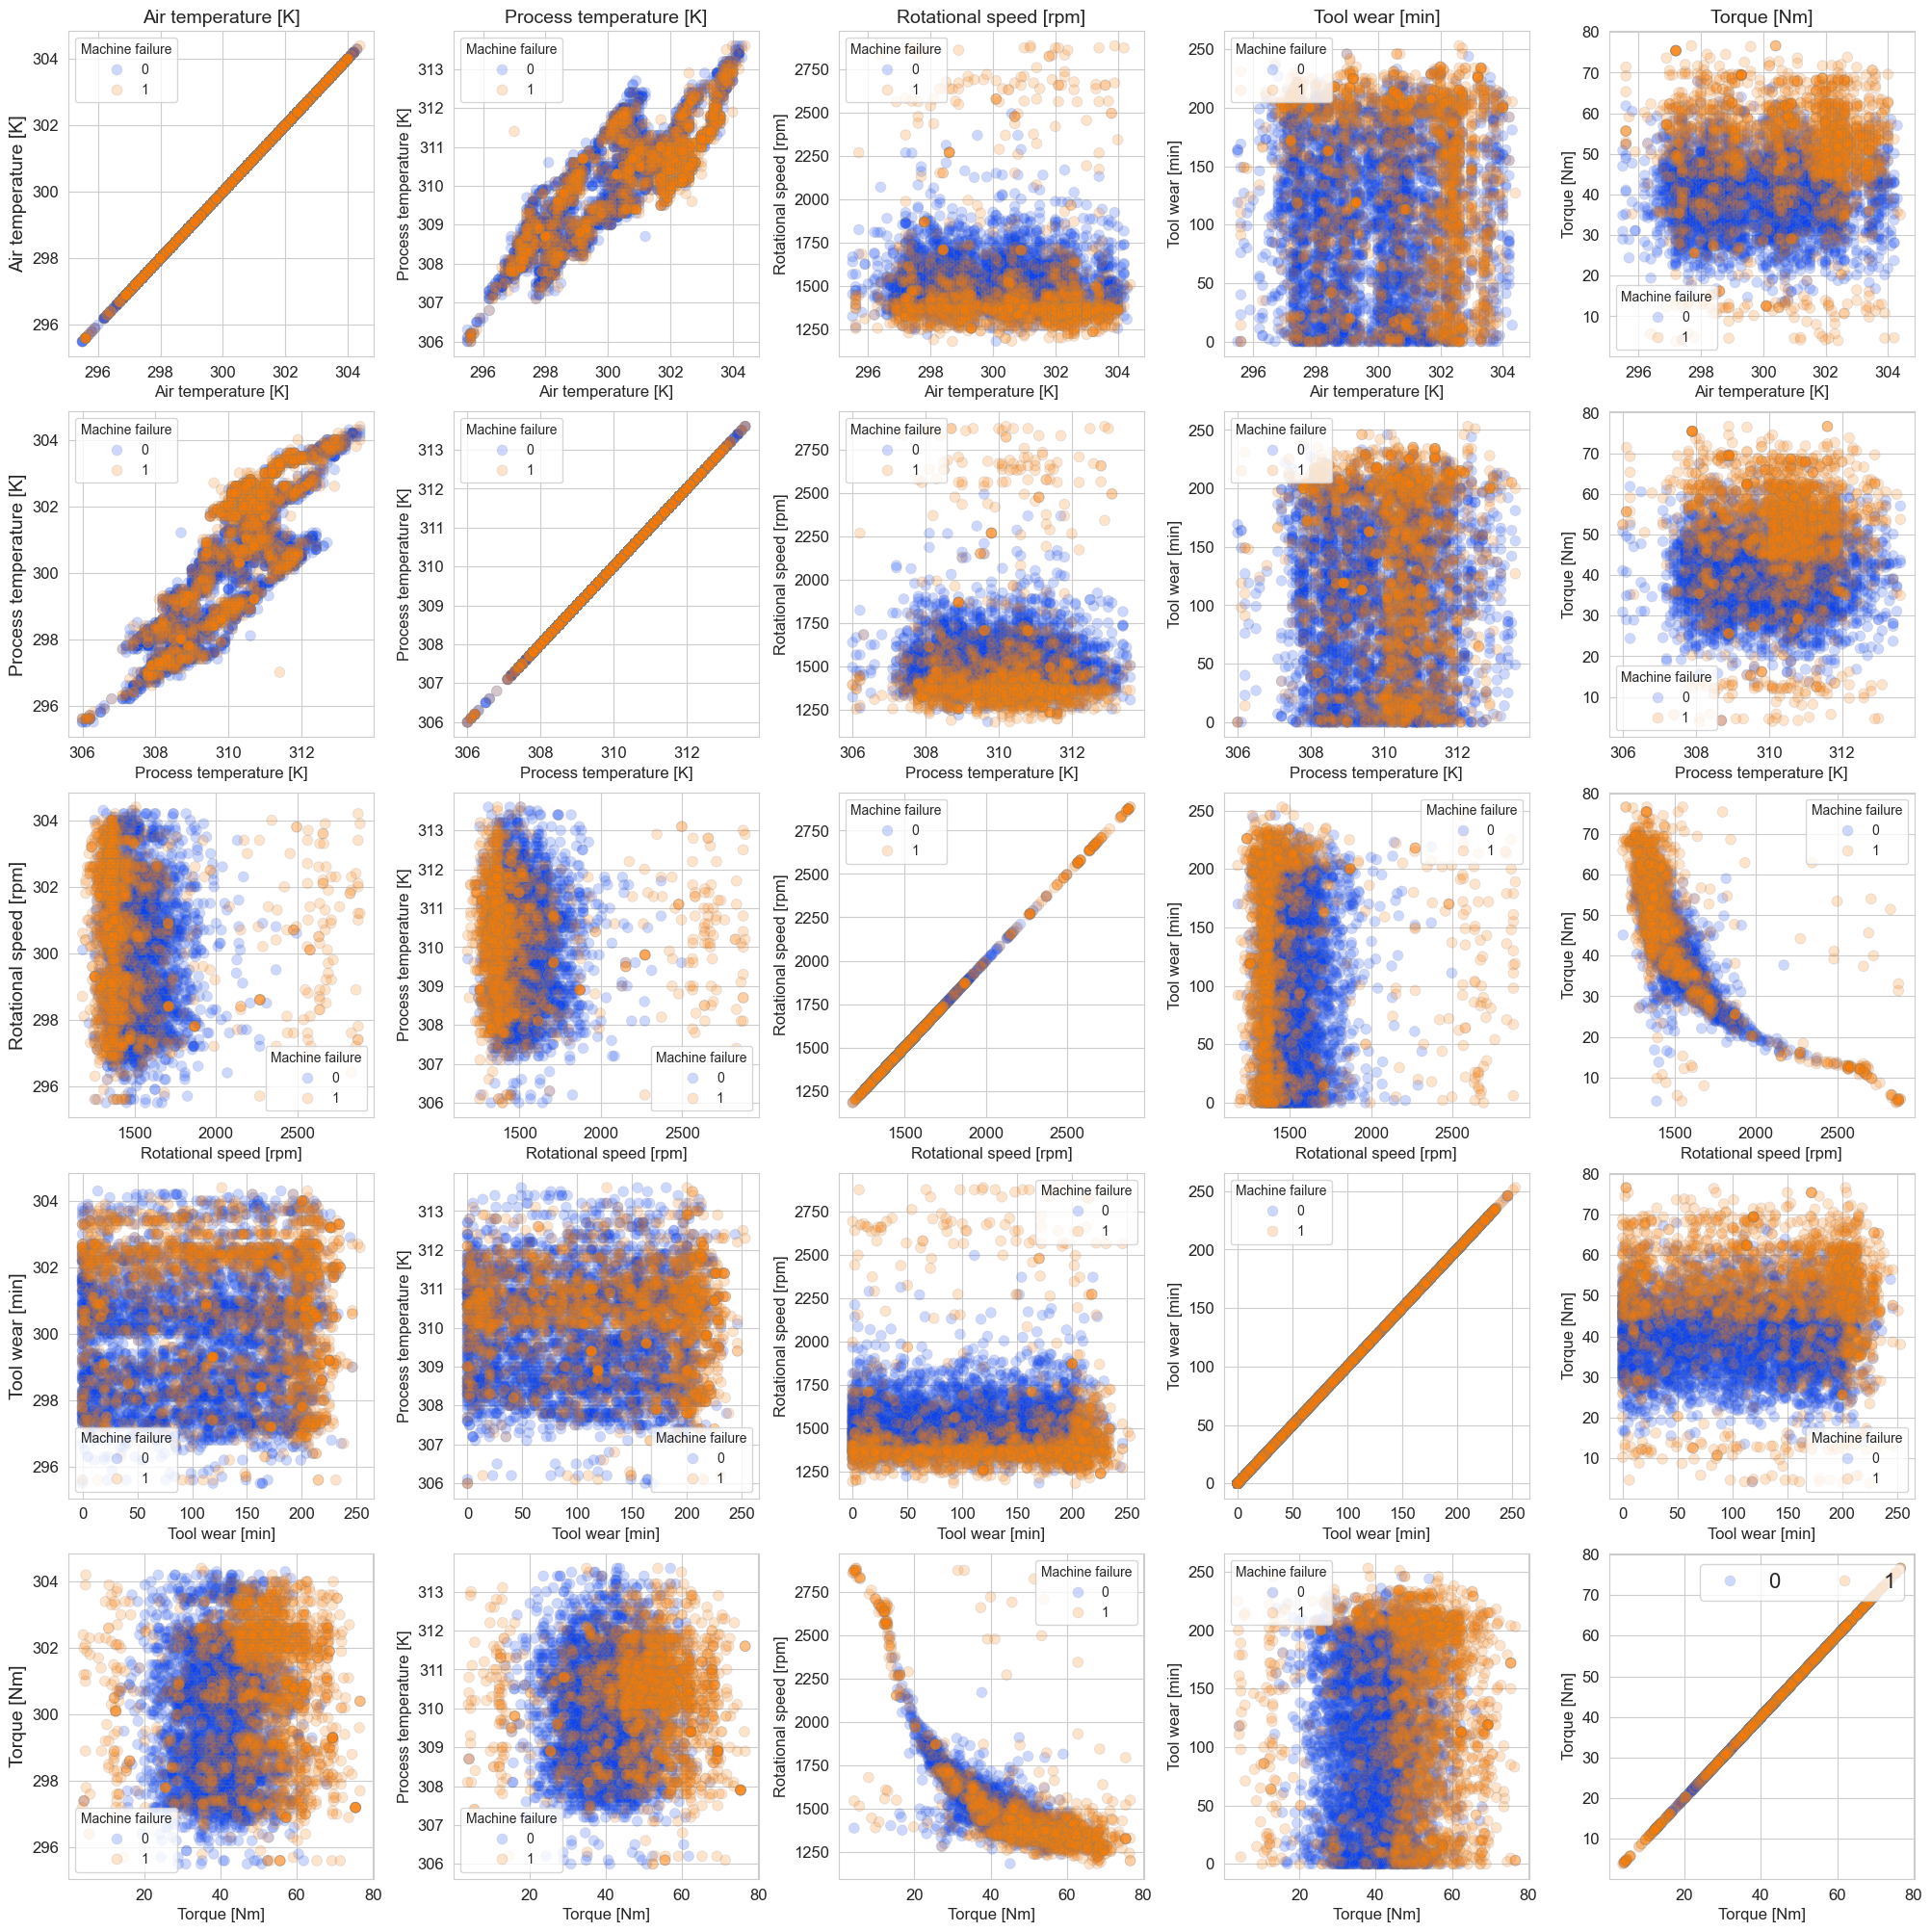

In [49]:
def plot_scatter_matrix(df, target_col):
  cols = df.columns.drop([target_col])
  fig, ax = plt.subplots(len(cols), len(cols), figsize=(4*len(cols), 4*len(cols)), sharex=False, sharey=False)

  for i, col in enumerate(cols):
    for j, col_ in enumerate(cols):
      ax[i,j].set_xlabel(f'{col}', fontsize=12)
      ax[i,j].set_ylabel(f'{col_}', fontsize=12)
      sns.scatterplot(data=df, x=col, y=col_, hue=target_col, ax=ax[i,j],
                      s=60, edgecolor='gray', alpha=0.2, palette='bright')
      ax[i,j].tick_params(axis='both', which='major', labelsize=12)

      if i == 0:
        ax[i,j].set_title(f'{col_}', fontsize=14)
      if j == 0:
        ax[i,j].set_ylabel(f'{col}', fontsize=14)

  plt.tight_layout(pad=0.5, h_pad=0.5, w_pad=0.5)
  plt.legend(loc='upper right', ncol=5, fontsize=16)
  plt.show()
    
rus = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
X_train_res, y_train_res = rus.fit_resample(df.drop(target_col, axis=1), df[target_col])
plot_scatter_matrix(pd.concat([X_train_res[num_cols], y_train_res], axis=1), target_col)

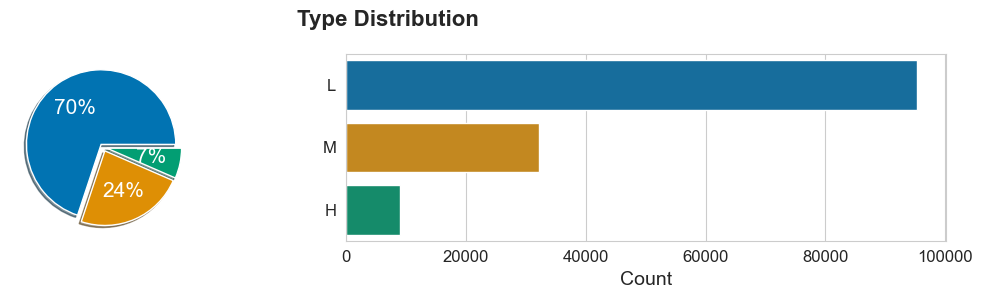

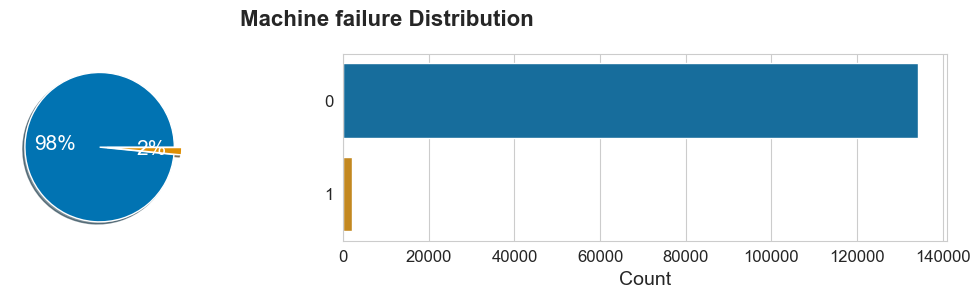

In [50]:
def plot_target_feature(df, target_col, palette='colorblind'):
  df = df.fillna('Nan')
  fig, ax = plt.subplots(1, 2, figsize=(12, 3))
  ax = ax.flatten()

  pie_colors = sns.color_palette(palette, len(df[target_col].unique()))
  ax[0].pie(
      df[target_col].value_counts(),
      shadow=True,
      explode=[0.05] * len(df[target_col].unique()),
      autopct='%1.f%%',
      textprops={'size': 15, 'color': 'white'},
      colors=pie_colors
  )
  ax[0].set_aspect('equal')

  bar_colors = sns.color_palette(palette)
  sns.countplot(
      data=df,
      y=target_col,
      ax=ax[1],
      palette=bar_colors
  )
  ax[1].set_xlabel('Count', fontsize=14)
  ax[1].set_ylabel('')
  ax[1].tick_params(labelsize=12)
  ax[1].yaxis.set_tick_params(width=0)

  fig.suptitle(f'{target_col} Distribution', fontsize=16, fontweight='bold')
  plt.tight_layout()
  plt.show()

plot_target_feature(df, 'Type')
plot_target_feature(df, target_col)

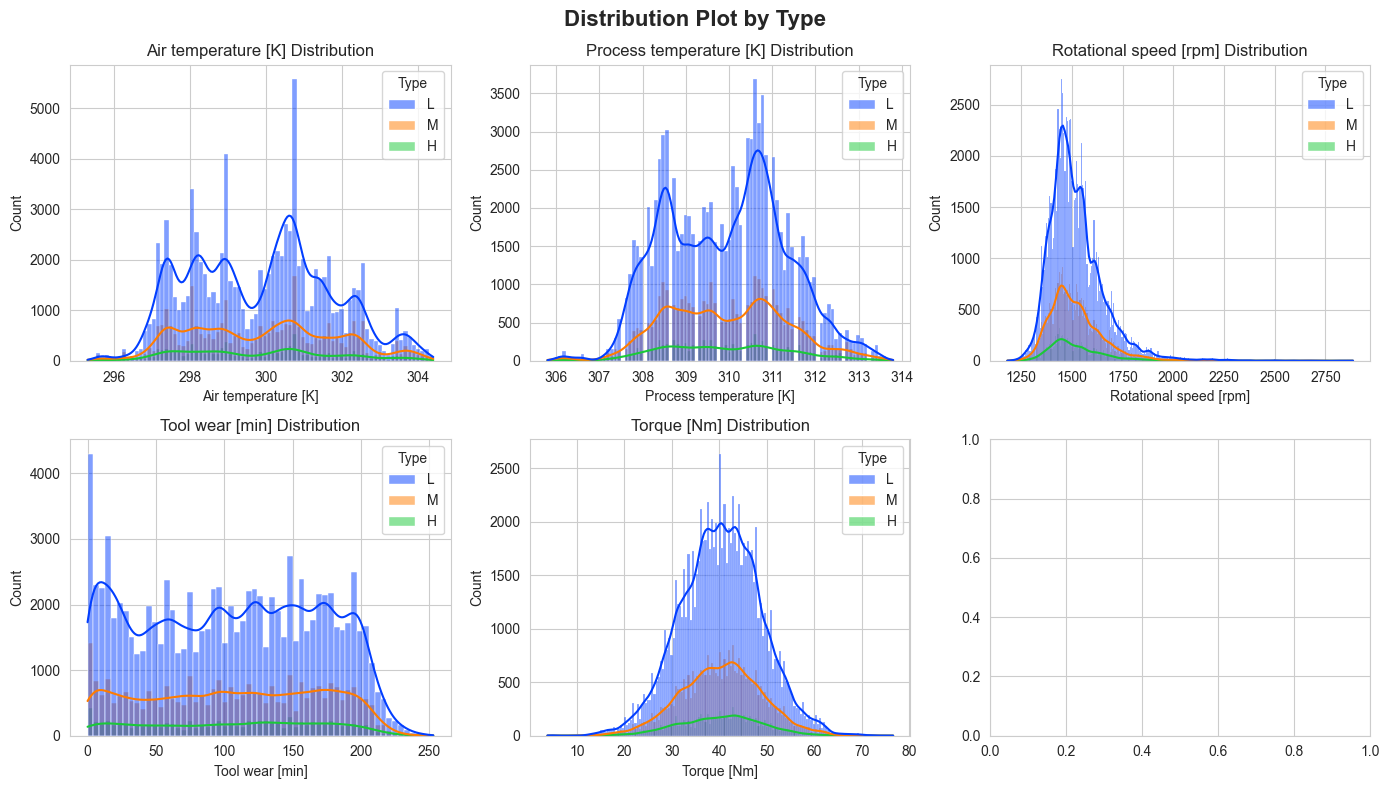

In [51]:
def plot_distribution(df, hue, n_cols = 3):
  cols = df.columns.drop([hue])
  n_rows = math.ceil(len(cols) / n_cols)

  fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(14, 4*n_rows))
  ax = ax.flatten()

  for i, col in enumerate(cols):
    sns.histplot(data=df, x=col, kde=True, ax=ax[i], hue=hue, palette='bright')
    ax[i].set_title(f'{col} Distribution')

  fig.suptitle(f'Distribution Plot by {hue}', fontweight='bold', fontsize=16)
  plt.tight_layout()
  plt.show()

plot_distribution(df[num_cols+['Type']], hue='Type')

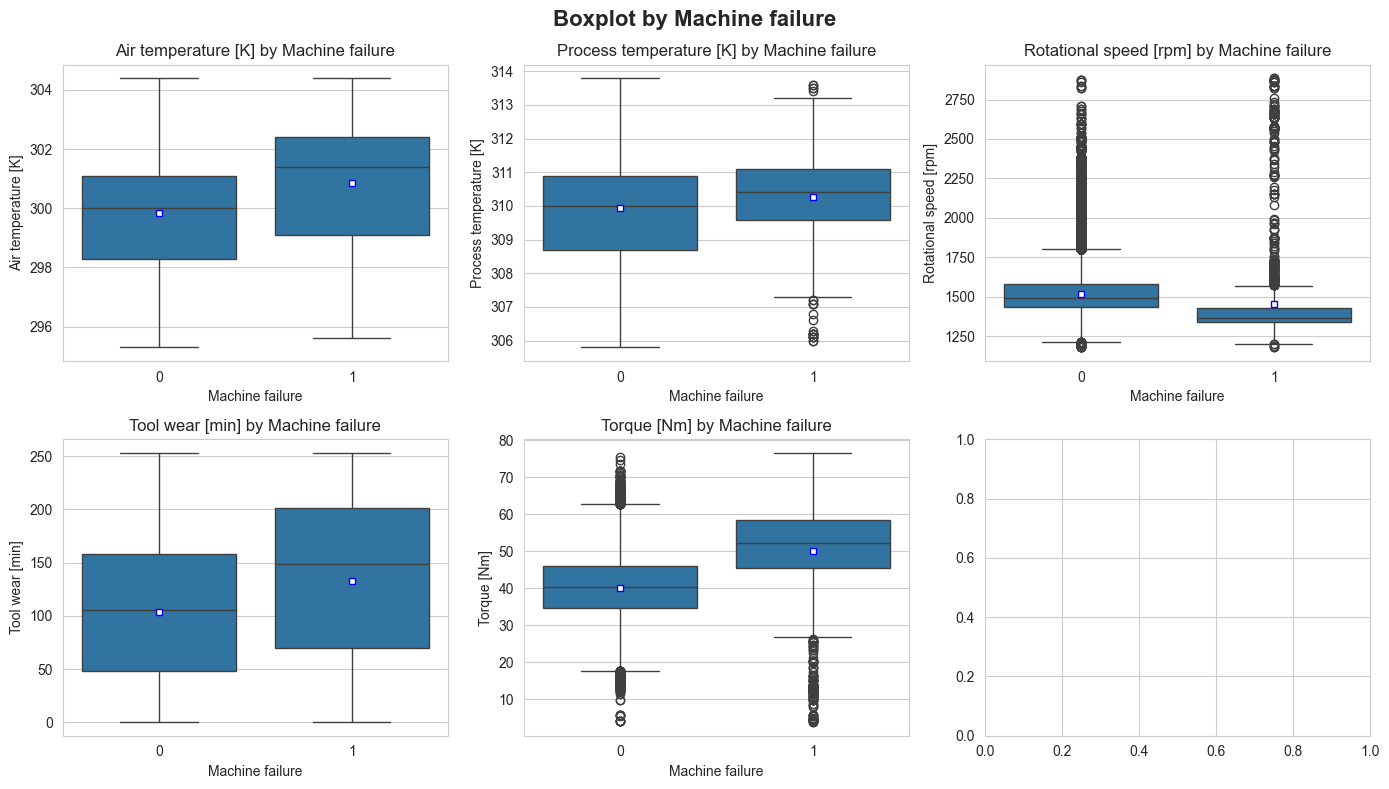

In [52]:
def plot_boxplot(df, hue, n_cols=3):
  cols = df.columns.drop([hue])
  n_rows = math.ceil(len(cols) / n_cols)

  fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(14, 4*n_rows))
  ax = ax.flatten()
  for i, col in enumerate(cols):
    sns.boxplot(data=df, x=hue, y=col, ax=ax[i], showmeans=True, 
                meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"blue", "markersize":"5"})
    ax[i].set_title(f'{col} by {hue}')

  fig.suptitle(f'Boxplot by {hue}', fontweight='bold', fontsize=16)
  plt.tight_layout()
  plt.show()
    
plot_boxplot(df[num_cols+[target_col]], hue=target_col, n_cols=3)

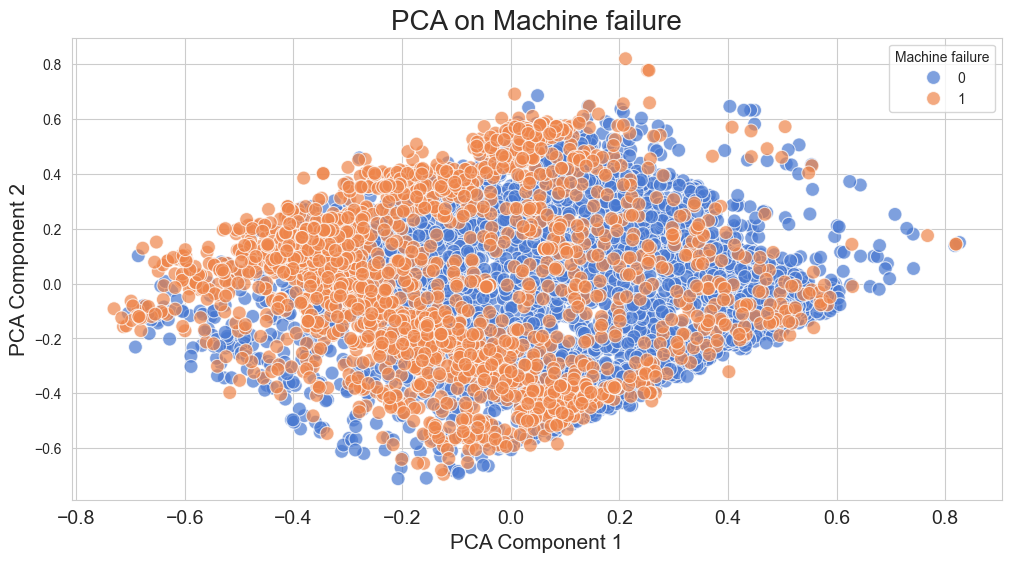

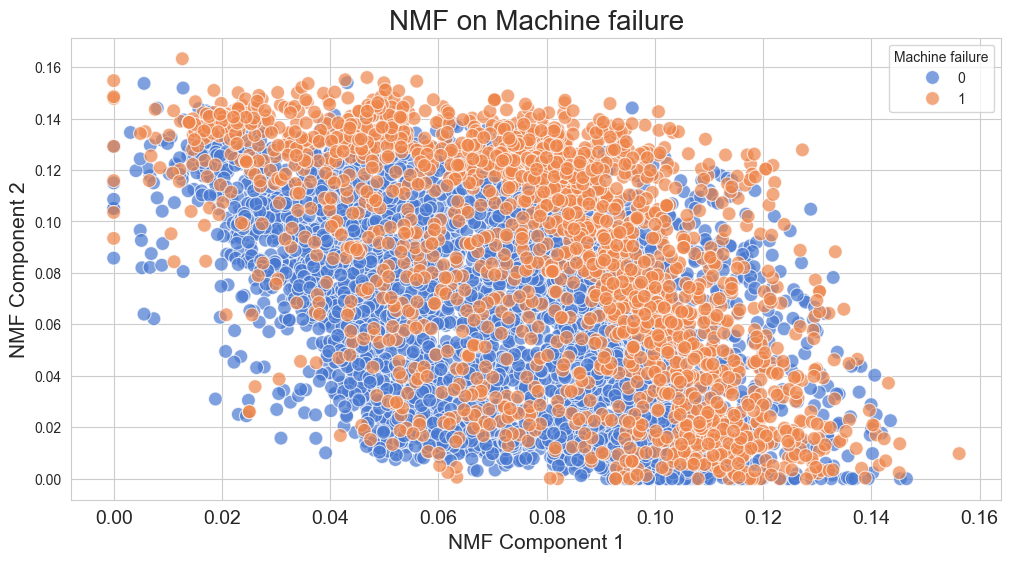

In [53]:
class Decomposition:
  def __init__(self, n_components, method="pca", scaler_method='standard'):
    self.n_components = n_components
    self.method = method
    self.scaler_method = scaler_method
      
  def dimension_reduction(self, df):
    X_reduced = self.dimension_method(df)
    df_comp = pd.DataFrame(X_reduced, columns=[f'{self.method.upper()}_{_}' for _ in range(self.n_components)], index=df.index)
    return df_comp
  
  def dimension_method(self, df):
    X = self.scaler(df)
    if self.method == "pca":
      pca = PCA(n_components=self.n_components, random_state=0)
      X_reduced = pca.fit_transform(X)
      self.comp = pca
    elif self.method == "nmf":
      nmf = NMF(n_components=self.n_components, random_state=0)
      X_reduced = nmf.fit_transform(X)
    else:
      raise ValueError(f"Invalid method name: {method}")
    
    return X_reduced
  
  def scaler(self, df):
    _df = df.copy()
    if self.scaler_method == "standard":
      return StandardScaler().fit_transform(_df)
    elif self.scaler_method == "minmax":
      return MinMaxScaler().fit_transform(_df)
    elif self.scaler_method == None:
      return _df.values
    else:
      raise ValueError(f"Invalid scaler_method name")
      
  def get_columns(self):
    return [f'{self.method.upper()}_{_}' for _ in range(self.n_components)]
  
  def get_explained_variance_ratio(self):
    return np.sum(self.comp.explained_variance_ratio_)
  
  def transform(self, df):
    X = self.scaler(df)
    X_reduced = self.comp.transform(X)
    df_comp = pd.DataFrame(X_reduced, columns=[f'{self.method.upper()}_{_}' for _ in range(self.n_components)], index=df.index)
    
    return df_comp
  
  def decomp_plot(self, tmp, label, hue='genre'):
    plt.figure(figsize = (12, 6))
    sns.scatterplot(x = f"{label}_0", y = f"{label}_1", data=tmp, hue=hue, alpha=0.7, s=100, palette='muted');

    plt.title(f'{label} on {hue}', fontsize = 20)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 10);
    plt.xlabel(f"{label} Component 1", fontsize = 15)
    plt.ylabel(f"{label} Component 2", fontsize = 15)
    
data = X_train_res[num_cols].copy()
for method in ['pca', 'nmf']:
  decomposition = Decomposition(n_components=2, method=method, scaler_method='minmax')
  decomposition_feature = decomposition.dimension_reduction(data)
  decomposition_feature = pd.concat([y_train_res, decomposition_feature], axis=1)
  decomposition.decomp_plot(decomposition_feature, method.upper(), target_col)

## FEATURE ENGINEERING

In [54]:
df['Product ID'] = df['Product ID'].str.replace('M','').str.replace('L','').str.replace('H','').astype(int)

In [55]:
data = df.copy()

In [56]:
data['Power'] = data['Torque [Nm]'] * data['Rotational speed [rpm]']
data['Temp Ratio'] = data['Process temperature [K]'] / data['Air temperature [K]']
data['Torque * Tool wear'] = data['Torque [Nm]'] * data['Tool wear [min]']
max_tool_wear = data['Tool wear [min]'].max()
data['Tool Wear Rate'] = data['Tool wear [min]'] / max_tool_wear
data.drop(['RNF'], axis=1, inplace=True)

In [16]:
# features_list = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
# for feat in features_list:
#   data[f'{feat} Squared'] = data[feat] ** 2
#   data[f'{feat} Log'] = data[feat].apply(lambda x: math.log(x) if x > 0 else 0)

In [17]:
# num_cols = df.select_dtypes(include=['number']).columns.difference([target_col]).difference(bin_cols).to_list()
# for col in num_cols:
#   if col not in ['Product ID', 'Rotational speed [rpm]']:
#     low = df[col].quantile(0.25)
#     high = df[col].quantile(0.75)
#     iqr = 1.5 * (high - low)
#     df[col] = df[col].clip(lower=low-iqr, upper=high+iqr)

#### Scaling And Encoding

In [57]:
num_cols = data.select_dtypes(include=['number']).columns.difference([target_col]).difference(bin_cols).difference(['Product ID']).to_list()

scaler = StandardScaler()
data[num_cols] = scaler.fit_transform(data[num_cols])

encoder = LabelEncoder()
col = ['Type', 'Product ID']
data[col] = data[col].apply(encoder.fit_transform)

#### Renaming Column

In [58]:
data.columns = data.columns.str.replace('\[.*?\]', '', regex=True)
data.columns = data.columns.str.replace(' ', '')
data.columns = data.columns.str.replace('[^a-zA-Z0-9]', '_', regex=True)

## Data Splitting

In [59]:
target_col = 'Machinefailure'
X = data.drop(target_col, axis=1).reset_index(drop=True)
y = data[target_col].reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [60]:
models = {
    'LGBM': lgb.LGBMClassifier(is_unbalance = True, random_state = 42, metric = 'auc'),
    'XGB': xgb.XGBClassifier(eval_metric='auc',random_state = 42,objective="binary:logistic"),
    'BRF' : BalancedRandomForestClassifier(random_state=42),
}

In [61]:
cv = StratifiedKFold(n_splits = 5, shuffle=True, random_state=42)
cv_splits = list(cv.split(X,y))

In [62]:
def train_classifier(clf,x_train,y_train,x_test,y_test, to_return= False):
  clf.fit(x_train,y_train)
  y_pred = clf.predict(x_test)
  score = roc_auc_score(y_test, clf.predict_proba(x_test)[:,1])
  if to_return is False:
    cm = confusion_matrix(y_pred, y_test)
    if score>0.92:
      print(f'{gren}{cm}')
      print(f'{gren}Ruc_score is {score}')
      print('*'*90)
    else:
      print(f'{red}{cm}')
      print(f"{red}Not a good model with score = {score}")
      print('x'*90)
    return clf
  return score

In [63]:
%%time
for i in range(len(models)):
  scores = []
  model = list(models.values())[i]
  print(f'{blu}{list(models.keys())[i]}')
  for j, (train_index, test_index) in enumerate(cv_splits):
    X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[test_index]
    
    score = train_classifier(model, X_train_fold, y_train_fold, 
                              X_val_fold, y_val_fold, to_return = True)
    scores.append(score)
  print(f'{blu} {scores}')
  mean_score = np.mean(scores)
  if mean_score>0.91:
    print(f'{gren}Mean Ruc_score is {mean_score}')
    print('*'*90)
  else:
    print(f"{red}Not a good model with Mean score = {mean_score}")
    print('x'*90)

LGBM
[LightGBM] [Info] Number of positive: 1719, number of negative: 107424
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2208
[LightGBM] [Info] Number of data points in the train set: 109143, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.015750 -> initscore=-4.135041
[LightGBM] [Info] Start training from score -4.135041
[LightGBM] [Info] Number of positive: 1718, number of negative: 107425
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011918 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2208
[LightGBM] [Info] Number of data points in the train set: 109143, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.015741 -> initscore=-4.135632
[LightGBM] [Info] Start training from score -4.135632
[Ligh

In [64]:
%%time
def brc_objective(trial):
  params = {
    'n_estimators': trial.suggest_int('n_estimators', 100, 500),
    'max_depth': trial.suggest_categorical('max_depth', [10, None]),
    'min_samples_split': trial.suggest_int('min_samples_split', 2, 5),
    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
    'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
  }

  classifier = BalancedRandomForestClassifier(**params, random_state = 42)
  classifier.fit(X_train, y_train)

  y_pred_proba = classifier.predict_proba(X_test)[:, 1]
  roc_auc = roc_auc_score(y_test, y_pred_proba)
  return roc_auc

study = optuna.create_study(direction='maximize')
study.optimize(brc_objective, n_trials=25)

brc_best_params = study.best_params
brc_best_score = study.best_value
print("Best Hyperparameters: ", brc_best_params)
print("Best ROC AUC Score: ", brc_best_score)

[I 2025-01-06 17:25:21,783] A new study created in memory with name: no-name-49a0e9a7-d910-4206-81ef-e4d13a81c7b9
[I 2025-01-06 17:25:31,980] Trial 0 finished with value: 0.9541185201349489 and parameters: {'n_estimators': 297, 'max_depth': None, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 0.9541185201349489.
[I 2025-01-06 17:25:44,694] Trial 1 finished with value: 0.9511433069393354 and parameters: {'n_estimators': 433, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9541185201349489.
[I 2025-01-06 17:25:58,163] Trial 2 finished with value: 0.9515738547013877 and parameters: {'n_estimators': 415, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9541185201349489.
[I 2025-01-06 17:26:01,957] Trial 3 finished with value: 0.9507834202741928 and parameters: {'n_estimators': 127, 'max_depth': 10, 

Best Hyperparameters:  {'n_estimators': 211, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}
Best ROC AUC Score:  0.9543583868487229
CPU times: total: 3min 59s
Wall time: 4min 8s


[[25012    50]
 [ 1844   380]]
Ruc_score is 0.9543583868487229
******************************************************************************************


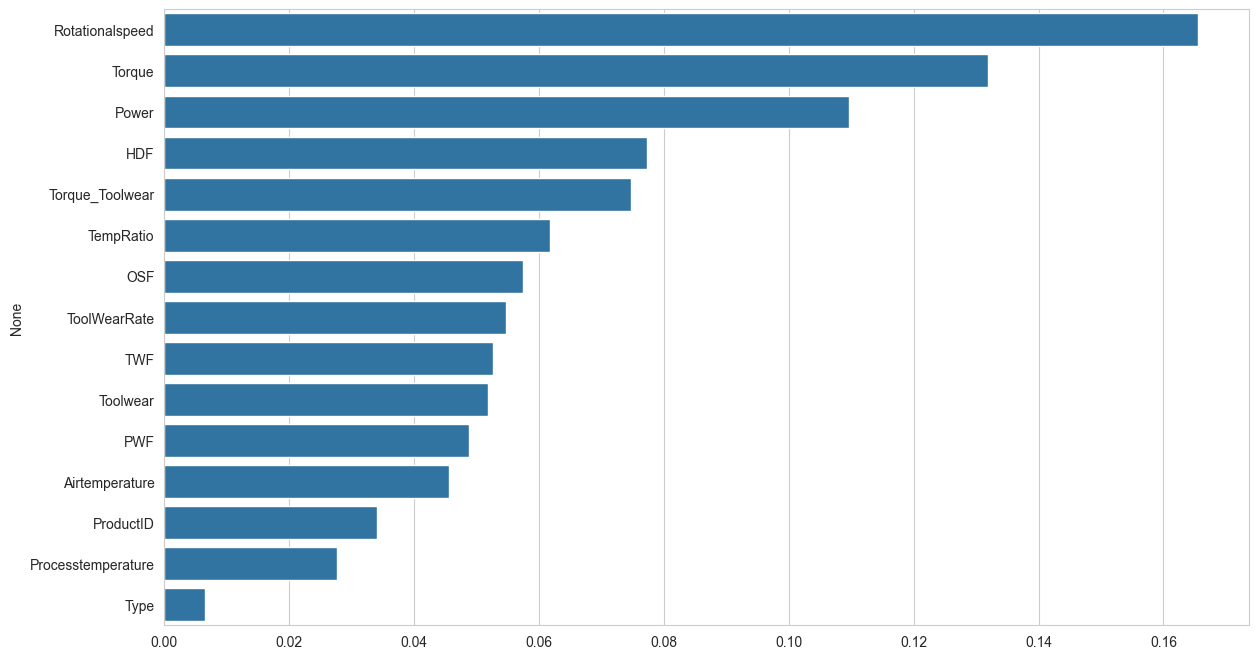

In [65]:
brc_model = BalancedRandomForestClassifier(**brc_best_params, random_state = 42)
train_classifier(brc_model, X_train, y_train, X_test, y_test)
plt.figure(figsize = (14, 8))
sns.barplot(y =X_train.columns, x =  brc_model.feature_importances_, 
            order=X_train.columns[np.argsort(-brc_model.feature_importances_)])
plt.show()

In [71]:
%%time
def xgb_objective(trial):
  params = {
    'n_estimators': trial.suggest_int('n_estimators', 100, 500),
    'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.3),
    'max_depth': trial.suggest_int('max_depth', 3, 15),
    'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
    'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
  }

  classifier = xgb.XGBClassifier(**params, random_state=42,eval_metric='auc',
                              objective = "binary:logistic", early_stopping_rounds=20)
  classifier.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
  y_pred_proba = classifier.predict_proba(X_test)[:, 1]
  roc_auc = roc_auc_score(y_test, y_pred_proba)
  return roc_auc

xgb_model = optuna.create_study(direction='maximize')
xgb_model.optimize(xgb_objective, n_trials=25)
xgb_best_params = xgb_model.best_params
xgb_best_score = xgb_model.best_value
print("XGB Best Hyperparameters: ", xgb_best_params)
print("XGB Best ROC AUC Score: ", xgb_best_score)

[I 2025-01-06 17:34:20,783] A new study created in memory with name: no-name-319e5e99-7267-4492-a5db-fe8c4b135cbf
[I 2025-01-06 17:34:22,352] Trial 0 finished with value: 0.9451208339394948 and parameters: {'n_estimators': 466, 'learning_rate': 0.0018677266592190735, 'max_depth': 4, 'subsample': 0.6362928477797287, 'colsample_bytree': 0.6513211979351905}. Best is trial 0 with value: 0.9451208339394948.
[I 2025-01-06 17:34:24,261] Trial 1 finished with value: 0.9484053626230506 and parameters: {'n_estimators': 438, 'learning_rate': 0.0021583590605437583, 'max_depth': 11, 'subsample': 0.5860757299064181, 'colsample_bytree': 0.5580415805518979}. Best is trial 1 with value: 0.9484053626230506.
[I 2025-01-06 17:34:24,819] Trial 2 finished with value: 0.9460366571759113 and parameters: {'n_estimators': 194, 'learning_rate': 0.010110210673111786, 'max_depth': 8, 'subsample': 0.9782106842243219, 'colsample_bytree': 0.7008575014652452}. Best is trial 1 with value: 0.9484053626230506.
[I 2025-01

XGB Best Hyperparameters:  {'n_estimators': 315, 'learning_rate': 0.17922495551982506, 'max_depth': 5, 'subsample': 0.8750461341457944, 'colsample_bytree': 0.5512319669985627}
XGB Best ROC AUC Score:  0.9586162808016571
CPU times: total: 3min
Wall time: 30.7 s


[[26843    90]
 [   13   340]]
Ruc_score is 0.9527631433104031
******************************************************************************************


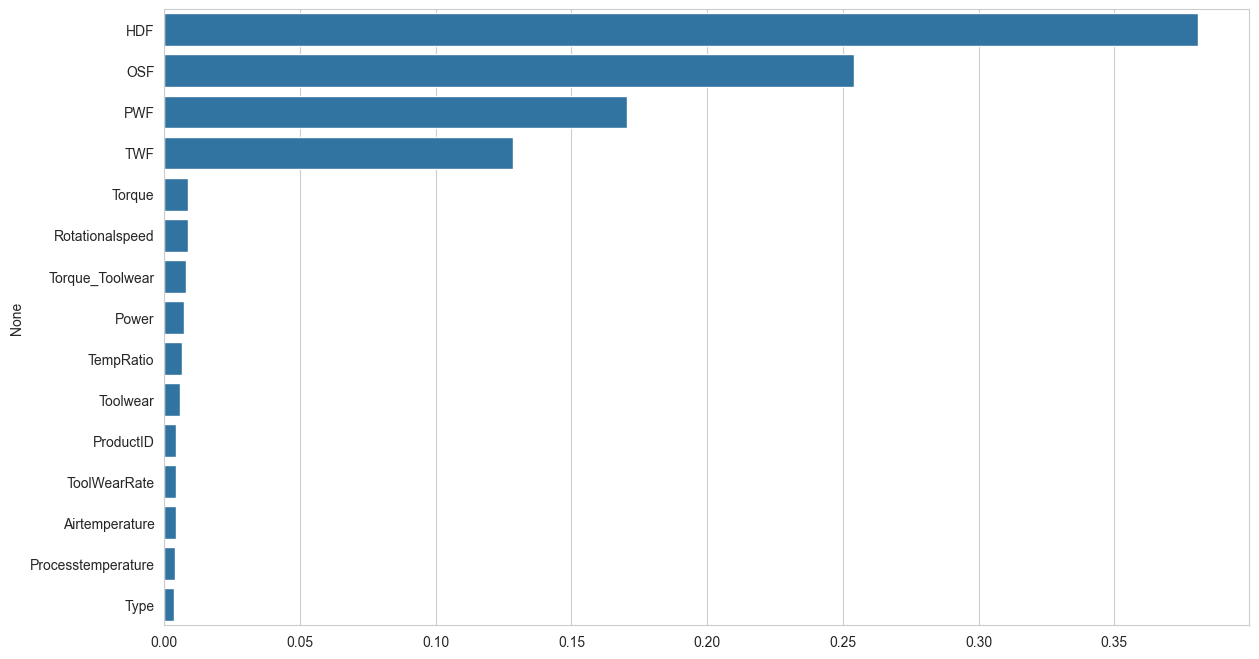

In [72]:
xgb_model = xgb.XGBClassifier(**xgb_best_params, objective = "binary:logistic", eval_metric='auc',random_state = 42)
train_classifier(xgb_model,X_train, y_train, X_test, y_test)
plt.figure(figsize = (14, 8))
sns.barplot(y =X_train.columns, x =  xgb_model.feature_importances_, 
            order=X_train.columns[np.argsort(-xgb_model.feature_importances_)])
plt.show()

In [75]:
%%time

# for lgbm model, remove info log and only keep error or warning logs

def lgb_objective(trial):
  params = {
    'n_estimators': trial.suggest_int('n_estimators', 100, 500),
    'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.3),
    'max_depth': trial.suggest_int('max_depth', 3, 15),
    'num_leaves': trial.suggest_int('num_leaves', 10, 100),
    'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
    'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
  }

  classifier = lgb.LGBMClassifier(**params, metric='auc', is_unbalance=True, random_state=42, verbosity=-1)
  classifier.fit(X_train, y_train, eval_set=[(X_test, y_test)])
  y_pred_proba = classifier.predict_proba(X_test)[:, 1]
  roc_auc = roc_auc_score(y_test, y_pred_proba)
  return roc_auc

lgb_model = optuna.create_study(direction='maximize')
lgb_model.optimize(lgb_objective, n_trials=25)
lgb_best_params = lgb_model.best_params
lgb_best_score = lgb_model.best_value
print("LGB Best Hyperparameters: ", lgb_best_params)
print("LGB Best ROC AUC Score: ", lgb_best_score)

[I 2025-01-06 17:37:44,987] A new study created in memory with name: no-name-5559f2f8-f7cc-4e69-9cb3-22648948e17e
[I 2025-01-06 17:37:49,064] Trial 0 finished with value: 0.9541102936592056 and parameters: {'n_estimators': 465, 'learning_rate': 0.001761173971670578, 'max_depth': 14, 'num_leaves': 36, 'subsample': 0.6707069741041956, 'colsample_bytree': 0.7192829832571728}. Best is trial 0 with value: 0.9541102936592056.
[I 2025-01-06 17:37:50,448] Trial 1 finished with value: 0.9362344216527769 and parameters: {'n_estimators': 225, 'learning_rate': 0.18548605038767654, 'max_depth': 5, 'num_leaves': 19, 'subsample': 0.8066177794692921, 'colsample_bytree': 0.7924241359127251}. Best is trial 0 with value: 0.9541102936592056.
[I 2025-01-06 17:37:55,242] Trial 2 finished with value: 0.9420005749873572 and parameters: {'n_estimators': 478, 'learning_rate': 0.13805725892897394, 'max_depth': 14, 'num_leaves': 38, 'subsample': 0.9922273632434775, 'colsample_bytree': 0.7478156961455871}. Best is

LGB Best Hyperparameters:  {'n_estimators': 457, 'learning_rate': 0.003043241638915769, 'max_depth': 15, 'num_leaves': 58, 'subsample': 0.5378113355200671, 'colsample_bytree': 0.7214564651542732}
LGB Best ROC AUC Score:  0.9545344767268671
CPU times: total: 6min 53s
Wall time: 1min 21s


[[26548    71]
 [  308   359]]
Ruc_score is 0.9545344767268671
******************************************************************************************


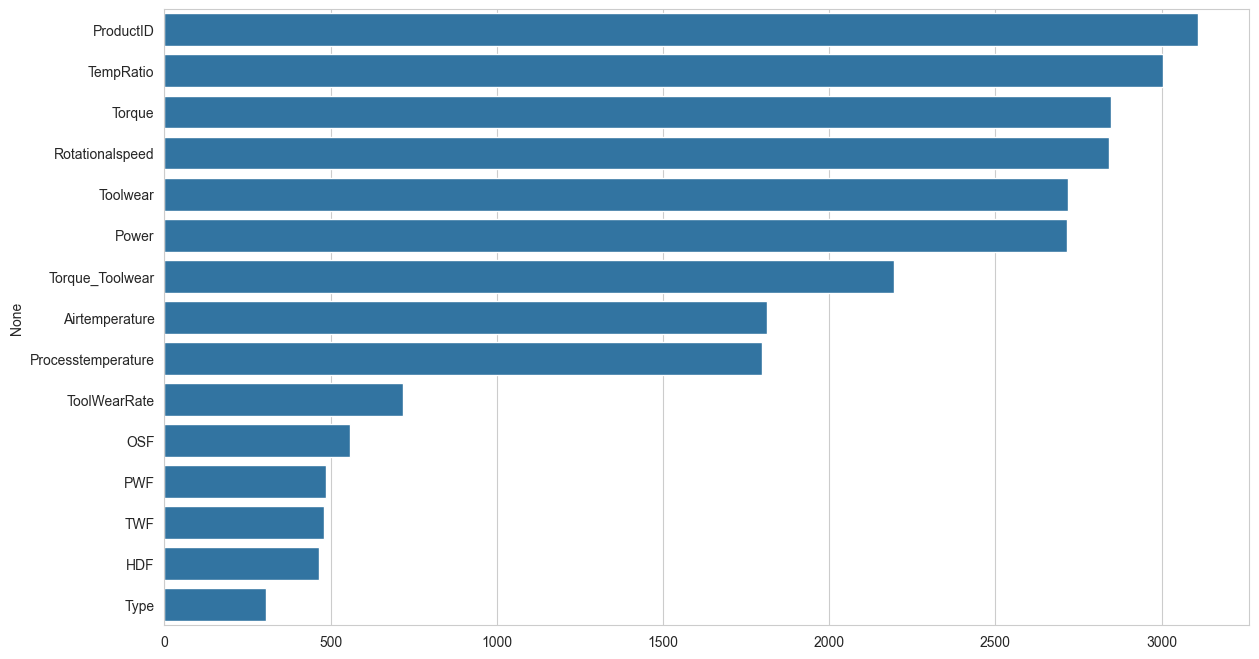

In [77]:
lgb_model = lgb.LGBMClassifier(**lgb_best_params, metric='auc', is_unbalance=True, random_state=42, verbosity=-1)
train_classifier(lgb_model,X_train, y_train, X_test, y_test)
plt.figure(figsize = (14, 8))
sns.barplot(y =X_train.columns, x =  lgb_model.feature_importances_, 
            order=X_train.columns[np.argsort(-lgb_model.feature_importances_)])
plt.show()

In [78]:
brf_model = BalancedRandomForestClassifier(**brc_best_params, random_state = 42)
xgb_model = xgb.XGBClassifier(**xgb_best_params, objective = "binary:logistic", eval_metric='auc',random_state = 42)
lgbm_model = lgb.LGBMClassifier(**lgb_best_params, metric='auc', is_unbalance=True, random_state=42, verbosity=-1)

vote = VotingClassifier(estimators=[('brf', brf_model), ('xgb', xgb_model), ('lgb', lgbm_model)], voting='soft')
train_classifier(vote, X_train, y_train, X_test, y_test)

[[26733    76]
 [  123   354]]
Ruc_score is 0.9560602281937778
******************************************************************************************


VotingClassifier(estimators=[('brf',
                              BalancedRandomForestClassifier(max_features='log2',
                                                             n_estimators=211,
                                                             random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.5512319669985627,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='auc',...
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=315, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                             ('lgb',
                              LGBMClassifier(colsample_bytree=0.7214564651542732,
                                             is_unbalance=True,
                                             learning_rate=0.003043241638915769,
                                             max_depth=15, metric='auc',
                                             n_estimators=457, num_leaves=58,
                                             random_state=42,
                                             subsample=0.5378113355200671,
                                             verbosity=-1))],
                 voting='soft')